# Mount the google drive project folder

In [17]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

In [ ]:
# %cd /content/gdrive/My Drive/ABSA-Project

/content/gdrive/My Drive/ABSA-Project


In [ ]:
# !ls

data	   notebooks		   stanford-corenlp-latest.zip
libraries  stanford-corenlp-4.0.0  stanford-tagger-4.0.0


# Aspect Based Sentiment Analysis

[SemEval-2016 Task 5](http://alt.qcri.org/semeval2016/task5/)



## Workflow



- Tasks are also subdivided into _out-of-domain_ and _in-domain_
- Various parts of the pipeline to obtain the Aspect Based Sentiment: 
  - Aspect term extraction
  - Aspect Category model
  - Sentiment Extraction
  - Sentiment Model

## SemEval 2016 Dataset

### Load the dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import load_raw_file

df = load_raw_file('restaurants', 'train', '2016')
df.head()

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


,rid,id,text,term,from,to,category,polarity
0,1004293,1004293:0,Judging from previous posts this used to be a ...,place,51,56,RESTAURANT#GENERAL,negative
1,1004293,1004293:1,"We, there were four of us, arrived at noon - t...",staff,75,80,SERVICE#GENERAL,negative
2,1004293,1004293:2,"They never brought us complimentary noodles, i...",NaN,0,0,SERVICE#GENERAL,negative
3,1004293,1004293:3,The food was lousy - too sweet or too salty an...,food,4,8,FOOD#QUALITY,negative
4,1004293,1004293:3,The food was lousy - too sweet or too salty an...,portions,52,60,FOOD#STYLE_OPTIONS,negative


### Basic Data Exploration questions

- How many unique categories do we have?
- What is the frequency of each category?
- What is the distribution of the number of opinion categories expressed in a text
- How many positive and negative sentiments are expressed?

### Prepare dataframe for a multi-label classification problem of Aspect Categories

In [2]:
df = df.loc[:, ['id', 'text', 'category']]
df.head()

,id,text,category
0,1004293:0,Judging from previous posts this used to be a ...,RESTAURANT#GENERAL
1,1004293:1,"We, there were four of us, arrived at noon - t...",SERVICE#GENERAL
2,1004293:2,"They never brought us complimentary noodles, i...",SERVICE#GENERAL
3,1004293:3,The food was lousy - too sweet or too salty an...,FOOD#QUALITY
4,1004293:3,The food was lousy - too sweet or too salty an...,FOOD#STYLE_OPTIONS


In [3]:
# One Hot Encode the categories
df = pd.get_dummies(df, columns=['category'], prefix='', prefix_sep='')
df.head()

,id,text,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE_OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE_OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL
0,1004293:0,Judging from previous posts this used to be a ...,0,0,0,0,0,0,0,0,1,0,0,0
1,1004293:1,"We, there were four of us, arrived at noon - t...",0,0,0,0,0,0,0,0,0,0,0,1
2,1004293:2,"They never brought us complimentary noodles, i...",0,0,0,0,0,0,0,0,0,0,0,1
3,1004293:3,The food was lousy - too sweet or too salty an...,0,0,0,0,0,1,0,0,0,0,0,0
4,1004293:3,The food was lousy - too sweet or too salty an...,0,0,0,0,0,0,1,0,0,0,0,0


In [4]:
# Now groupby each sentence id and combine the labels to make it a multi-label classification

df =  df.groupby(['id', 'text']).apply(lambda x: (x.sum() >= 1).astype(int)).reset_index()
df.head()

,id,text,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE_OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE_OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL
0,1004293:0,Judging from previous posts this used to be a ...,0,0,0,0,0,0,0,0,1,0,0,0
1,1004293:1,"We, there were four of us, arrived at noon - t...",0,0,0,0,0,0,0,0,0,0,0,1
2,1004293:2,"They never brought us complimentary noodles, i...",0,0,0,0,0,0,0,0,0,0,0,1
3,1004293:3,The food was lousy - too sweet or too salty an...,0,0,0,0,0,1,1,0,0,0,0,0
4,1004293:4,"After all that, they complained to me about th...",0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
def prepare_df_aspcat(df):
    df = df.loc[:, ['id', 'text', 'category']]
    df = pd.get_dummies(df, columns=['category'], prefix='', prefix_sep='')
    df =  df.groupby(['id', 'text']).apply(lambda x: (x.sum() >= 1).astype(int)).reset_index()

    return df

## Text Preprocessing

In [6]:
import nltk
import re
import string
import inflect

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# lower case
def lower_case(text):
    return text.lower()

# remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', text)

# convert number into words 
def convert_number(text): 
    p = inflect.engine()   
    # split string into list of words 
    temp_str = text.split() 
    # initialise empty list 
    new_string = [] 
  
    for word in temp_str: 
        # if word is a digit, convert the digit 
        # to numbers and append into the new_string list 
        if word.isdigit(): 
            temp = p.number_to_words(word) 
            new_string.append(temp) 
  
        # append the word as it is 
        else: 
            new_string.append(word) 
  
    # join the words of new_string to form a string 
    temp_str = ' '.join(new_string) 
    return temp_str 
  

# remove punctuation 
def remove_punctuation(text): 
    translator = str.maketrans('', '', string.punctuation) 
    return text.translate(translator)


from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
# remove stopwords function 
def remove_stopwords(text): 
    stop_words = set(stopwords.words("english")) 
    word_tokens = word_tokenize(text) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return ' '.join(filtered_text)
   


from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
lemmatizer = WordNetLemmatizer() 
# lemmatize string 
def lemmatize_word(text): 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    return ' '.join(lemmas)

[nltk_data] Downloading package stopwords to /home/abhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/abhi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/abhi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
def preprocess_text(text):
    text = lower_case(text)
    text = convert_number(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = lemmatize_word(text)

    return text


### Extracting aspect terms using POS tagging

In [8]:
import spacy
nlp = spacy.load('en')
reviews = df.text.str.lower()

aspect_terms = []
for review in nlp.pipe(reviews):
    chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
df['aspect_terms'] = aspect_terms
df.head(10)

,id,text,AMBIENCE#GENERAL,DRINKS#PRICES,DRINKS#QUALITY,DRINKS#STYLE_OPTIONS,FOOD#PRICES,FOOD#QUALITY,FOOD#STYLE_OPTIONS,LOCATION#GENERAL,RESTAURANT#GENERAL,RESTAURANT#MISCELLANEOUS,RESTAURANT#PRICES,SERVICE#GENERAL,aspect_terms
0,1004293:0,Judging from previous posts this used to be a ...,0,0,0,0,0,0,0,0,1,0,0,0,posts place
1,1004293:1,"We, there were four of us, arrived at noon - t...",0,0,0,0,0,0,0,0,0,0,0,1,noon place staff
2,1004293:2,"They never brought us complimentary noodles, i...",0,0,0,0,0,0,0,0,0,0,0,1,noodles requests sugar dishes table
3,1004293:3,The food was lousy - too sweet or too salty an...,0,0,0,0,0,1,1,0,0,0,0,0,food portions
4,1004293:4,"After all that, they complained to me about th...",0,0,0,0,0,0,0,0,0,0,0,1,tip
5,1004293:5,Avoid this place!,0,0,0,0,0,0,0,0,1,0,0,0,place
6,1014458:0,"I have eaten at Saul, many times, the food is ...",0,0,0,0,0,1,0,0,0,0,0,0,food
7,1014458:1,Saul is the best restaurant on Smith Street an...,0,0,0,0,0,0,0,0,1,0,0,0,restaurant
8,1014458:2,The duck confit is always amazing and the foie...,0,0,0,0,0,1,0,0,0,0,0,0,confit figs world
9,1014458:3,The wine list is interesting and has many good...,0,1,0,1,0,0,0,0,0,0,0,0,list values


In [9]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(reviews)
X = tokenizer.texts_to_matrix(reviews)
y = df.drop(['id', 'text', 'aspect_terms'], axis=1).values

### Process the test dataset

In [10]:
df_test = load_raw_file('restaurants', 'test', '2016')
df_test = prepare_df_aspcat(df_test)

def extract_aspect_terms(df):
    nlp = spacy.load('en')
    reviews = df.text.str.lower()

    aspect_terms = []
    for review in nlp.pipe(reviews):
        chunks = [(chunk.root.text) for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
        aspect_terms.append(' '.join(chunks))
        
        
    df['aspect_terms'] = aspect_terms

    return df

def get_X_y(df, tokenizer):
    reviews  = df.text
    X = tokenizer.texts_to_matrix(reviews)
    y = df.drop(['id', 'text', 'aspect_terms'], axis=1).values

    return X, y

df_test = extract_aspect_terms(df_test)
X_test, y_test = get_X_y(df_test, tokenizer)





### Aspect Category Classification

### Class imbalance

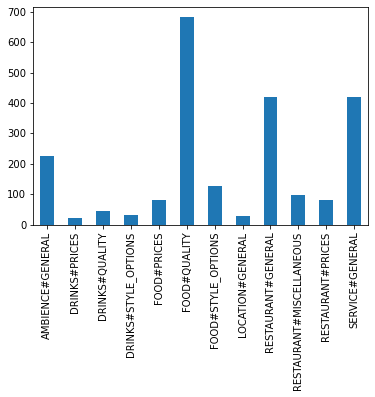

In [26]:
df.iloc[:, 2:].drop('aspect_terms', axis=1).sum().plot(kind='bar')

In [11]:
from utils import custom_f1

In [12]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

asp_cat_model = Sequential()
asp_cat_model.add(Dense(512, input_shape=(6000,), activation='relu'))
asp_cat_model.add(Dense(12, activation='sigmoid'))
asp_cat_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[custom_f1, 'accuracy'])

In [13]:
asp_cat_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               3072512   
_________________________________________________________________
dense_2 (Dense)              (None, 12)                6156      
Total params: 3,078,668
Trainable params: 3,078,668
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = asp_cat_model.fit(X, y, epochs=10, batch_size=64, validation_data=[X_test, y_test],  verbose=1)

Train on 1708 samples, validate on 587 samples
Epoch 1/10
1708/1708 [==============================] - 2s 1ms/step - loss: 0.0679 - custom_f1: 0.9120 - acc: 0.9820 - val_loss: 0.1852 - val_custom_f1: 0.6337 - val_acc: 0.9388
Epoch 2/10
1708/1708 [==============================] - 2s 1ms/step - loss: 0.0529 - custom_f1: 0.9388 - acc: 0.9873 - val_loss: 0.1860 - val_custom_f1: 0.6434 - val_acc: 0.9397
Epoch 3/10
1708/1708 [==============================] - 2s 1ms/step - loss: 0.0418 - custom_f1: 0.9600 - acc: 0.9915 - val_loss: 0.1881 - val_custom_f1: 0.6499 - val_acc: 0.9399
Epoch 4/10
1708/1708 [==============================] - 2s 1ms/step - loss: 0.0338 - custom_f1: 0.9730 - acc: 0.9942 - val_loss: 0.1920 - val_custom_f1: 0.6583 - val_acc: 0.9408
Epoch 5/10
1708/1708 [==============================] - 2s 1ms/step - loss: 0.0277 - custom_f1: 0.9816 - acc: 0.9960 - val_loss: 0.1953 - val_custom_f1: 0.6652 - val_acc: 0.9412
Epoch 6/10
1708/1708 [==============================] - 2s 1ms/